# A IPython Notebook to analyze the Gaza-Israel 2012 crisis

The Guardian is tracking and mapping live ([link](http://www.guardian.co.uk/news/datablog/interactive/2012/nov/19/gaza-israel-verified-incidents-mapped)) the recent incidents in Gaza and Israel. As part of their data-journalism spirit, they are sharing the data as a Google Fusion Table available for access.

This notebook is an attempt to show, on the one hand, how the toolkit from the Python stack can be used for a real world data hack and, on the other, to offer deeper analysis beyond mapping of the events, both exploiting the spatial as well as the temporal dimension of the data.

+ The source document (`.ipynb` file) is stored on Github as a gist [here](https://gist.github.com/4121857), which means you can fork it and use it as a start for you own data-hack.
+ A viewable version is available [here](http://nbviewer.ipython.org/4121857/), via the IPython Notebook Viewer.

## Collaborate on the notebook!!!

In its initial version (Nov. 20th), the notebook only contains code to stream the data from the Google Fusion Table into a [`pandas`](http://pandas.pydata.org) DataFrame (which means you get the data ready to hack!). Step in and collaborate in making it a good example of how Python can help analyze real world data. Add a new view, quick visualization, summary statistic of fancy model that helps understand the data better!

To contribute, just fork the gist as you would with any git repository.

*Happy hacking!*

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import urllib2, urllib
import pandas as pd
from StringIO import StringIO

The following cell pulls the data using the API. In the meantime, Google has changed its terms and ways to access it, so this might not work.

In [2]:
def parse_loc(loc, ret_lon=True):
    try:
        lon, lat = loc.split(',')
        lon, lat = lon.strip(' '), lat.strip(' ')
        lon, lat = map(float, [lon, lat])
        if ret_lon:
            return lon
        else:
            return lat
    except:
        return None

If you cannot pull the data using the API, an easy alternative is to export the table to a `csv` file manually and read it separately:

In [3]:
db = pd.read_csv('data.csv')

In [4]:
db['lon'] = db['Location (approximate)'].apply(lambda x: parse_loc(x))
db['lat'] = db['Location (approximate)'].apply(lambda x: parse_loc(x, ret_lon=False))
db['Date'] = db['Date'].apply(pd.to_datetime)
db.head()

,Date,Day,Name of place,Location (approximate),Details,Source url,Image url,Icon 1,lon,lat
0,2012-11-16,Friday,Beit Lahia,"31.5515, 34.5089",Firefighters try to extinguish a fire at a fac...,http://www.guardian.co.uk/news/2012/nov/16/pic...,http://static.guim.co.uk/sys-images/Guardian/P...,placemark_circle_highlight,31.551500,34.508900
1,2012-11-15,Thursday,Police Station in Deir al-Balah,"31.4205, 34.3513",Israeli aircraft also bombed a police station ...,Wires,NaN,placemark_circle_highlight,31.420500,34.351300
2,2012-11-15,Thursday,Beit Hanoun,"31.5382, 34.5380","Brothers Tareq Jamal Naser, 16, and Oday Jamal...",http://www.maannews.net/eng/ViewDetails.aspx?I...,NaN,placemark_circle_highlight,31.538200,34.538000
3,2012-11-15,Thursday,Sheikh Radwan neighborhood,"31.536297, 34.465828",Violent explosions across Gaza City's Sheikh R...,http://www.maannews.net/eng/ViewDetails.aspx?I...,NaN,placemark_circle_highlight,31.536297,34.465828
4,2012-11-15,Thursday,Tel Aviv,"32.0718, 34.777",Two rockets from Gaza crashed near Tel Aviv on...,http://www.guardian.co.uk/world/2012/nov/15/is...,NaN,placemark_circle_highlight,32.071800,34.777000


## Very basic descriptive analysis

+ Volume of incidents by day

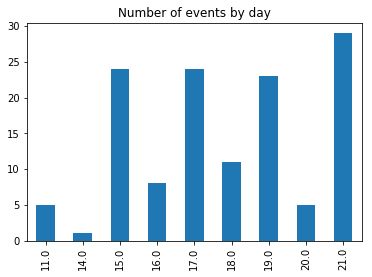

In [5]:
t = db['Date']
t = t.reindex(t)
by_day = t.groupby(lambda x: x.day).size()
by_day.plot(kind='bar')
plt.title('Number of events by day')
plt.show()

+ Location of events coloured by day

In [6]:
import matplotlib.cm as cm

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  del sys.path[0]


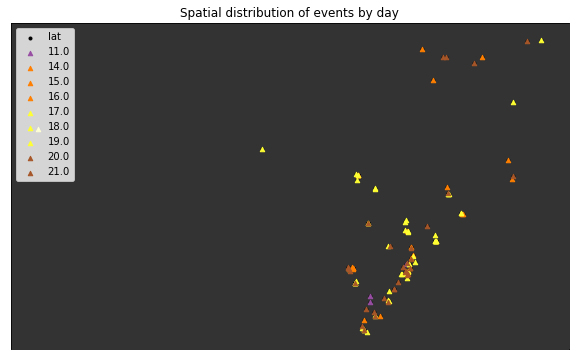

In [7]:
f = plt.figure(figsize=(10, 6))
ax = f.add_subplot(111)
x, y = db['lon'], db['lat']
s = plt.scatter(x, y, marker='.', color='k')
for d, day in db.set_index('Date').groupby(lambda x: x.day):
    x, y = day['lon'], day['lat']
    c = cm.Set1(d/30.)
    s = plt.scatter(x, y, marker='^', color=c, label=str(d), s=20)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.legend(loc=2)
plt.title('Spatial distribution of events by day')
ax.set_axis_bgcolor("0.2") 

In [11]:
# You'll need cartopy for a pretty map
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import matplotlib.cm as cm

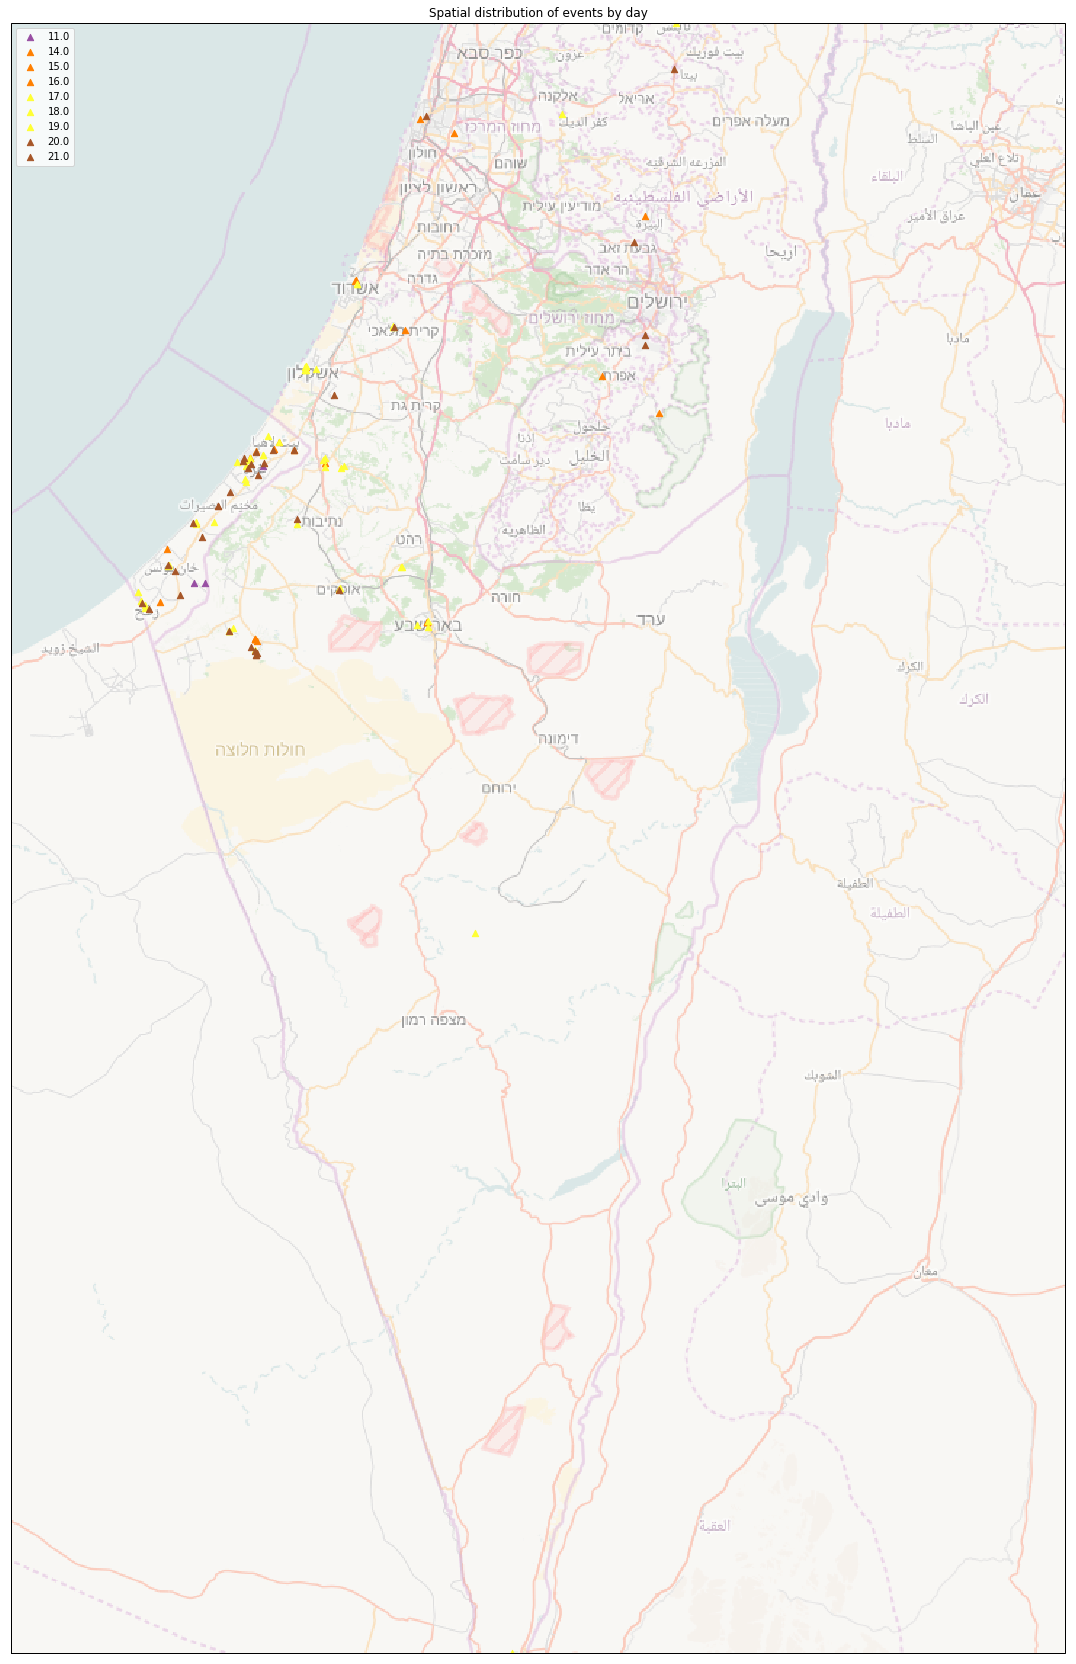

In [14]:
bg = cimgt.OSM()
src = ccrs.PlateCarree()

f = plt.figure(figsize=(20, 30))
ax = plt.axes(projection=bg.crs)
ax.add_image(bg, 9, alpha=0.5)

x, y = db['lon'], db['lat']
extent = [y.min(), y.max(), x.min(), 34]
extent = [34, 36, x.min(), x.max()] #Manually tweaked
for d, day in db.set_index('Date').groupby(lambda x: x.day):
    y, x = day['lon'], day['lat']
    c = cm.Set1(d/30.)
    s = plt.scatter(x, y, marker='^', color=c, label=str(d), s=40, \
                    transform=src)
ax.set_extent(extent, crs=src)
plt.legend(loc=2)
plt.title('Spatial distribution of events by day')
plt.show()